In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA
from simple_plot import *
import pandas
pandas.__version__

'0.23.0'

# Ch. 8 - Finite Difference Methods

We now make the leap from ordinary differential equations (ODEs) to __partial differential equations (PDEs)__ that involve more than one independent variable. The chapter starts looking at how to apply finite difference methods similar to those introduced in Ch. 7, and then moves on to consider an alternative approach based on Fourier transforms.

Before we get into the details, let's quickly review classification of PDEs that arise frequently in engineering. Let's start with the general __$2^{nd}$-order Quasi-linear PDE__. 
$$A(x,y) \frac{\partial^2 u}{\partial x^2}+2B(x,y) \frac{\partial^2 u}{\partial x \partial y}+C(x,y) \frac{\partial^2 u}{\partial y^2} = F(x,y,u, \frac{\partial u}{\partial x}, \frac{\partial u}{\partial y})$$

It is common to use $x,y,z, \text{and } t$ as independent variables, so we will designate the dependent variable as $u$, $\psi$, or $\omega$. It is also common to use subscripts (sometimes preceded by a comma) as shorthand for partial derivatives, so the equation above can also be written as:
$$A(x,y) \, u_{xx}+2B(x,y) \, u_{xy}+C(x,y) \, u_{yy} = F(x,y,u, u_x, u_y)$$
If the PDE has __constant coefficients__, then things simplify a bit:
$$A  u_{xx}+2B  u_{xy}+C  u_{yy} = F(x,y,u, u_x, u_y)$$
The usual approach to classification focuses on the highest ($2^{nd}$) order derivatives and considers __characteristic solutions__ of the form $u = f(k x + y)$.

Using the chain rule we find: $$u_x = k f', u_y = f'$$

Plugging into the PDE gives: $$A k^2 f' +2 B k f' + c f' = 0$$

Cancelling $f'$ leaves a quadratic equation to solve for k: $$A k^2 + 2 B k + C = 0$$

The major distinction of interesst involves whether the equation has real roots. 

For real values of $k$:

- values of $u(k x + y)$ are constant along __real characteristic curves (or lines or directions)__ $k x + y =0 $

- information propagates along real characteristics

- "propagates" \implies wave behavior

Existence of real characteristics exist is determined by the __discriminant__ $B^2 - A C$, and the classifications are summarized in the table below:



|   Type        |     Discriminant Value      |   Classic Example   |      Classic Equation    |    Normal Form Equation   |
| -------- | :------------------: | :--------: | :-------------: | :--------------: |
| Hyperbolic     |  $B^2-A C>0$  | Wave |  $u_{tt} = c^2 u_{xx}$     | $u_{vw} = f_1$ |
| Parabolic      |  $B^2-A C=0$  | Heat |  $u_{t} = c^2 u_{xx}$     | $u_{ww} = f_2$ |
| Elliptic      |  $B^2-A C<0$  | Laplace |  $u_{xx} + u_{yy} = 0$     | $u_{vv}+u_{ww} = f_3$ |

We will see that the different classes of equations will have different properties that require choosing appropriate numerical methods.

## Section 8.1 - Finite Difference Discretization

This section in the text opens with a non-trivial example, but let's look at some of the "classics" first starting with Laplace's equation which arises in a variety of applications including gravitation, electrostatics, fluid flow, and just about anything with a potential.

### Laplace Equation - Simple Iterative Solution

Starting simple with Cartesian coordinates and Dirichlet boundary conditions (BCs), let's compute a numerical solution for the following problem:

$$ \nabla^2 u = \frac{\partial^2u}{\partial x^2} + \frac{\partial^2u}{\partial y^2} = 0 \text{ on } x \in [0,L_x]; \; y \in [0,L_y]$$

with boundary conditions:

$$u(0,y)=u(L,y)=u(0,x)=0, \; u(L,x) = U$$

Just as we did for the direct solve method of ODEs, we will discretize the domain to produce a regular grid. Let $n_x$ be the number of grid points interior to the domain along the $x$ direction, so that there will be $n_x + 2$ along the axis (including a boundary point at each end of the interval). There will be $n_x+1$ intervals along the axis, so the spacing between the nodes is $\Delta x = L_x/(n_x + 1)$, and the discrete coordinate values are $x_i = (i+1) \Delta x, \; i \in [0,n_x -1]$. 

(Here we have maintained python indexing (`i in range(nx)`) in the interior, so the boundary corresponds to $x_{-1} = 0$ and $x_{nx} = Lx$.)


In [2]:
Lx = 1
nx = 4
x = np.linspace(0,Lx,nx + 2) #linspace across full domain including boundaries
dx = Lx/(nx+1) #spacing between nodes
x_in = x[1:-1] #x-coords of interior points

Similarly for $y$, the spacing between the nodes is $\Delta y = L_y/(n_y + 1)$, and the discrete coordinate values are $y_j = (j+1) \Delta y, \; j \in [0,n_y -1]$

In [3]:
Ly = 1
ny = 4
y = np.linspace(0,Ly,ny + 2) #linspace across full domain including boundaries
dy = Ly/(ny+1) #spacing between nodes
y_in = y[1:-1] #y-coords of interior points
y_in

array([0.2, 0.4, 0.6, 0.8])

In [4]:
mg = np.meshgrid(x,y)
mg

[array([[0. , 0.2, 0.4, 0.6, 0.8, 1. ],
        [0. , 0.2, 0.4, 0.6, 0.8, 1. ],
        [0. , 0.2, 0.4, 0.6, 0.8, 1. ],
        [0. , 0.2, 0.4, 0.6, 0.8, 1. ],
        [0. , 0.2, 0.4, 0.6, 0.8, 1. ],
        [0. , 0.2, 0.4, 0.6, 0.8, 1. ]]),
 array([[0. , 0. , 0. , 0. , 0. , 0. ],
        [0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
        [0.4, 0.4, 0.4, 0.4, 0.4, 0.4],
        [0.6, 0.6, 0.6, 0.6, 0.6, 0.6],
        [0.8, 0.8, 0.8, 0.8, 0.8, 0.8],
        [1. , 1. , 1. , 1. , 1. , 1. ]])]

Now the continuous domain has been replaced by a discrete grid of points, $(x_i, y_j)$, and we aim to solve for the values of the dependent variable on the grid:

$$u_{i,j} = u(x_i, y_j) = u\big( (i+1) \Delta x, (j+1) \Delta y \big)$$ 

We get an equation for each (internal) grid point by replacing the derivatives with central difference approximations:

\begin{equation}
\begin{split}
\frac{\partial^2u}{\partial x^2} & \rightarrow \frac{1}{\Delta x^2}(u_{i-1,j}-2u_{i,j}+u_{i+1,j}) \\
\frac{\partial^2u}{\partial y^2} & \rightarrow \frac{1}{\Delta y^2} (u_{i,j-1} -2 u_{i,j} + u_{i,j+1})
\end{split}
\end{equation}

Each equation then takes the form :

$$ \nabla^2 u = \frac{\partial ^2 u}{\partial x^2} + \frac{\partial^2u}{\partial y^2} \rightarrow u_{i-1,j}+u_{i+1,j}+u_{i,j-1} + u_{i,j+1} -4u_{i,j} = 0$$

This quantity is more readable in code format:

`u[i-1,j] + u[i+1,j] + u[i,j-1] + u[i,j+1] - 4*u[i,j]`

This is a classic __stencil computation__: we can think about obtaining this quantity byplacing a stencil of coefficients on top of a grid point and performing an "inner product" by multiplying the stencil coefficient by the grid value it covers and then summing. Here we need a "5-point stencil" also referred to as a __tensor product stencil of radius 1__ (because we are using a 1D stencil along each coordinate direction covering 1 neighbor in each direction. The specific stencil is shown below where red/black dots indicate stencil coefficients of $-4$ and $1$ respectively:

![stencil_5point](stencil_5point.png)

If there are no source terms (so the right-hand side of the previous equation is zero, then we can solve for $u_{i,j}$ in terms of the values at the neighboring gridpoints:

$$u_{i,j} = \frac{1}{4} (u_{i-1,j} + u_{i+1,j} +u_{i,j-1} +u_{i,j+1} )$$

and we can employ this as the basis for an explicit iterative solver:

$$u^{k+1}_{i,j} = \frac{1}{4} (u^k_{i-1,j} + u^k_{i+1,j} +u^k_{i,j-1} +u^k_{i,j+1} )$$

Interpreting $k$ as iteration number, the equation suggests repeatedly updating each grid point with the average of the values at the neighboring grid points. Let's implement this and see how it works:

In [5]:
# write a function to update each value as mean of neighbors
def mean_update(u):
    '''
    update 2D array with non-boundary elements replaced by average of 4 nearest neighbors (on Cartesian grid)
    
    Args:
        u: 2D numpy array of floats
        
    Returns:
        u_new: numpy array with same shape as u
    '''
    #insert code here
    nx,ny = u.shape
    #u_new = np.zeros([nx,ny])
    u_new = np.copy(u)
    for i in range(1,nx-1):
        for j in range(1,ny-1):
            u_new[i,j]=(u[i-1,j]+u[i+1,j]+u[i,j-1]+u[i,j+1])/4.
    return u_new

Create an array initialized with the Dirichlet BCs on the boundary and zeros in the interior:

In [6]:
u = np.zeros([nx,ny])
top_val = 100
#impose BCs
for j in range(ny):
    u[0,j] = top_val
u

array([[100., 100., 100., 100.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.]])

Test the `mean_update` function:

In [7]:
u_new = mean_update(u)
u_new

array([[100., 100., 100., 100.],
       [  0.,  25.,  25.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.]])

That looks OK, so run a larger version:

### Sample implementation of iterative Laplace solver below:

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA
from simple_plot import *

# write a function to update each value as mean of neighbors
def mean_update(u):
    '''
    update 2D array with non-boundary elements replaced by average of 4 nearest neighbors (on Cartesian grid)
    
    Args:
        u: 2D numpy array of floats
        
    Returns:
        u_new: numpy array with same shape as u
    '''
    nx, ny = np.shape(u)
    u_new = np.copy(u)
    for i in range(1,nx-1):
        for j in range(1,ny-1):
            u_new[i,j] = (u[i-1,j]+u[i+1,j]+u[i,j-1]+u[i,j+1])/4.
    return u_new

In [9]:
#from IPython.core.debugger import set_trace
#set_trace()

#intialize x discretization
Lx = 1
nx = 35
x = np.linspace(0,Lx,nx + 2) #linspace across full domain including boundaries
dx = Lx/(nx+1) #spacing between nodes
x_in = x[1:-1] #x-coords of interior points

#intialize y discretization
Ly = 1
ny = 20
y = np.linspace(0,Ly,ny + 2) #linspace across full domain including boundaries
dy = Ly/(ny+1) #spacing between nodes
y_in = y[1:-1] #y-coords of interior points
y_in

#intialize the 2D array
u = np.zeros([nx+2,ny+2]) #include boundary points
top_val = 100
#impose BCs
for j in range(ny+2):
    u[0,j] = top_val

tol = 1e-2
max_iter = 60
du = np.zeros(max_iter)
for k in range(max_iter):
    u_new = mean_update(u)
    du_max = np.max(np.abs(u-u_new))
    du[k] = du_max
    u = u_new
    if du_max < tol:
        break
np.set_printoptions(precision=2)
print(u)
np.set_printoptions(precision=5)
print(du)
np.set_printoptions(precision=2)

[[1.00e+02 1.00e+02 1.00e+02 1.00e+02 1.00e+02 1.00e+02 1.00e+02 1.00e+02
  1.00e+02 1.00e+02 1.00e+02 1.00e+02 1.00e+02 1.00e+02 1.00e+02 1.00e+02
  1.00e+02 1.00e+02 1.00e+02 1.00e+02 1.00e+02 1.00e+02]
 [0.00e+00 4.90e+01 6.77e+01 7.60e+01 8.02e+01 8.24e+01 8.37e+01 8.45e+01
  8.49e+01 8.51e+01 8.52e+01 8.52e+01 8.51e+01 8.49e+01 8.45e+01 8.37e+01
  8.24e+01 8.02e+01 7.60e+01 6.77e+01 4.90e+01 0.00e+00]
 [0.00e+00 2.82e+01 4.60e+01 5.64e+01 6.25e+01 6.61e+01 6.83e+01 6.96e+01
  7.04e+01 7.08e+01 7.10e+01 7.10e+01 7.08e+01 7.04e+01 6.96e+01 6.83e+01
  6.61e+01 6.25e+01 5.64e+01 4.60e+01 2.82e+01 0.00e+00]
 [0.00e+00 1.80e+01 3.19e+01 4.14e+01 4.77e+01 5.18e+01 5.43e+01 5.59e+01
  5.69e+01 5.75e+01 5.77e+01 5.77e+01 5.75e+01 5.69e+01 5.59e+01 5.43e+01
  5.18e+01 4.77e+01 4.14e+01 3.19e+01 1.80e+01 0.00e+00]
 [0.00e+00 1.22e+01 2.25e+01 3.03e+01 3.58e+01 3.97e+01 4.22e+01 4.39e+01
  4.49e+01 4.55e+01 4.58e+01 4.58e+01 4.55e+01 4.49e+01 4.39e+01 4.22e+01
  3.97e+01 3.58e+01 3.03e+01 2.2

C:\Users\storti\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


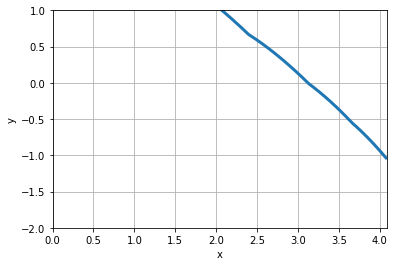

In [10]:
t = range(max_iter)
arrayplot(np.log(t), np.log(du), axis_range=[0,np.log(max_iter),-2,1],grid=True)

In [11]:
x.shape, y.shape, u.shape

((37,), (22,), (37, 22))

In [12]:
X,Y = np.meshgrid(x,y)
X.shape,Y.shape,u.shape

((22, 37), (22, 37), (37, 22))

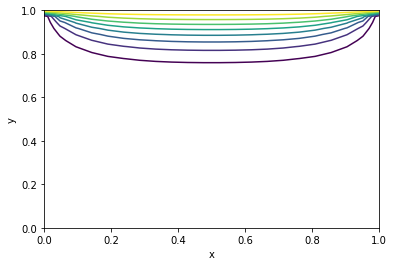

In [13]:
arraycontourplot(1-x,y, u, levels=np.linspace(0,100,10),
    titlestring='', filled=False)

# PICK UP HERE THURSDAY 2/20

### Laplace Equation - Direct Solve

The approach implemented above uses the central difference operator to create a stencil that can be used to repeatedly update values on the 2D grid so that the 2D array of values converges to an approximat solution of the Laplace equation.

Here we consider an alternative __direct solve__ view where we again collect the discretized equations for the full grid of nodes into one big system to be solved for the full grid of values. Because the PDE is linear, the system of equations will be linear, so it is convenient to recast the problem into the traditional $A x = b$ form. How do you do that when the unknowns correspond to a 2-dimensional array instead of a 1-dimensional array? The usual approach is to  __flatten__ the $n \times n$ 2D array into a $n^2 \times 1$ 1D array: instead of stacking the rows on top of one another to create a matrix, concatenate one row after another in 1 long vector (i.e., a 1D numpy array).

To be concrete, the 2D array is:


$$
\begin{equation}
\boldsymbol{u}_{2D} = 
\begin{bmatrix}
u[0,0] & u[0,1] & u[0,2] & u[0,3] \\
u[1,0] & u[1,1] & u[1,2] & u[1,3] \\
u[2,0] & u[2,1] & u[2,2] & u[2,3] \\
u[3,0] & u[3,1] & u[3,2] & u[3,3]  
\end{bmatrix}
\end{equation}
$$

and the stencil is:
$$
\begin{equation}
\boldsymbol{u}_{2D} = 
\begin{bmatrix}
0 & 1 & 0  \\
1  &-4 & 1  \\
0 & 1 & 0 
\end{bmatrix}
\end{equation}
$$

The 2D array flattens into the following 1D array:
$$
\begin{equation}
\boldsymbol{u}_{1D} =
\begin{bmatrix}
   u[0,0]   \\
   u[0,1]   \\
   u[0,2]   \\
   u[0,3]   \\
   u[1,0]   \\
   u[1,1]   \\
   u[1,2]   \\
   u[1,3]   \\
   u[2,0]   \\
   u[2,1]   \\
   u[2,2]   \\
   u[2,3]   \\
   u[3,0]   \\
   u[3,1]   \\
   u[3,2]   \\
   u[3,3]
\end{bmatrix} 
\end{equation}
$$

and applying the stencil at each node on the grid produces a linear system of equations $A \boldsymbol{u}_{1D} = \boldsymbol{b}$. 

__Look at a typical row and identify the coefficients associated with the node at the center of the stencil and its left, right, top, and bottom neighbors.__



$$
\begin{equation}
A \boldsymbol{u}_{2D} = 
\begin{bmatrix}
-4 & 1 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
1 & -4 & 1 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & -4 & 1 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & -4 & 1 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
1 & 0 & 0 & 0 & -4 & 1 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 1 & -4 & 1 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 1 & -4 & 1 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 1 & -4 & 1 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & -4 & 1 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 1 & -4 & 1 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 1 & -4 & 1 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 1 & -4 & 1 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & -4 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 1 & -4 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 1 & -4 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 1 & -4 \\ 
\end{bmatrix}
\begin{bmatrix}
   u[0,0]   \\
   u[0,1]   \\
   u[0,2]   \\
   u[0,3]   \\
   u[1,0]   \\
   u[1,1]   \\
   u[1,2]   \\
   u[1,3]   \\
   u[2,0]   \\
   u[2,1]   \\
   u[2,2]   \\
   u[2,3]   \\
   u[3,0]   \\
   u[3,1]   \\
   u[3,2]   \\
   u[3,3]
\end{bmatrix}
=
\begin{bmatrix}
   -U   \\
   -U   \\
   -U   \\
   -U   \\
   0   \\
   0   \\
   0   \\
   0   \\
   0   \\
   0   \\
   0   \\
   0   \\
   0   \\
   0   \\
   0   \\
   0
\end{bmatrix}
\end{equation}
$$

The non-zero entries in $\boldsymbol b$ arise in rows corresponding to grid points adjacent to non-homogeneous boundary values.

The array has a structure that is more clearly revealed by writing it as a block matrix:
$$
\begin{equation}
A = 
\begin{bmatrix}
B & I & 0 & 0 \\
I & B & I & 0 \\
0 & I & B & I \\
0 & 0 & I & B
\end{bmatrix}
\end{equation}
$$

where $I$ is the $4 \times 4$ identity matrix, $0$ is a $4 \times 4$ matrix of zeros and
$$
\begin{equation}
B = 
\begin{bmatrix}
-4 & 1 & 0 & 0 \\
1 & -4 & 1 & 0 \\
0 & 1 & -4 & 1 \\
0 & 0 & 1 & -4
\end{bmatrix}
\end{equation}
$$

Note that your matrix will be different around the edges as you adjust for different boundary conditions. For example, Eq. (8.1.14) in the text considers periodic boundary conditions resulting in having $I$ instead of $0$ in the lower left and upper right positions in the block matrix.

### Coding exercise

So now is the time for some coding exercise. Write a function to construct the matrix for an $n \times n$ grid. Also, write a function to construct the corresponding vector $\boldsymbol b$.

So how would you go about doing this? We have seen that we can construct block arrays with `numpy.blocks` and specify diagonal values of a banded matrix with`scipy.sparse.diags`. How would we combine these to constuct a block banded array? And what kind of structure should we use?

Consider a fully `numpy` approach. What issues might we run into?

- Memory allocation: The size of a `numpy` array has to be specified and allocated in advance, so we can't just append new pieces to build the block array.

- Assignment to subarrays: `numpy` does NOT support assignment to subarrays, so the assignment of values from a block into the block-banded matrix has to be done one element at a time.

So jumping directly into `numpy` does not seem like the correct approach. The data structure that allows us to build up by appending elements is the python `list` structure (which also happens to be the desired form of the input for constructing arrays with`numpy.array` and `numpy.block`).

So a sensible approach goes as follows:

1) Define the desired blocks, `B(n), I(n), O(n)`, using `scipy.sparse.diags`.

2) Write a `list_diags` function similar to `diags` that constructs a doubly nested list with given values on the diagonals in the desired band.

3) Call `list_diags` with the list of desired blocks as an argument to create the nested list `nest`.

4) Call `numpy.block(nest)` to create the desired `numpy` array.

With that plan, fill in the code below:

In [ ]:
from scipy.sparse import diags
import pdb #in case you need to do some bebugging
#pdb.set_trace() #set a breakpoint

def B(n):
    '''
    construct nxn tridiagonal 2D array with entries 1,-4,1 on the diagonals
    
    Args:
        n: integer size of square array
        
    Returns:
        arr: nxn 2D tridiagonal numpy array 
    '''
    # insert code here
    # if you create a sparse array, remember to use toarray() so you return something you can view
    return arr

# create shorthand for standard numpy arrays
def I(n):
    return np.eye(n)

def O(n):
    return np.zeros([n,n])

In [215]:
#test your functions
n=4
print("B= \n", B(n))
#etc

B= 
 [[-4.  1.  0.  0.]
 [ 1. -4.  1.  0.]
 [ 0.  1. -4.  1.]
 [ 0.  0.  1. -4.]]


In [ ]:
def list_diags(value, offset, fill, n):
    '''
    construct nxn nested list of with entries in 'value' on diagonals with given 'offset' (and 'fill' elsewhere)
    
    Args:
        value: list of values
        offset: list of offsets from main diagonal
        fill: default value elsewhere in the nested list
        n: integer size for length of list along each dimension
        
    Returns:
        nest: nxn nested list
    '''
    nest = [[fill for j in range(n)] for i in range(n)] #list comprehension to create nxn nested list
    #insert code here
    return nest

def block_diags(val, offset, fill, n):
    '''
    construct n**n x n**n 2D block diagonal numpy array 
    
    Args:
        value: list of block arrays
        offset: list of block offsets from main diagonal
        fill: default block elsewhere in the block array
        n: integer size for each square block
        
    Returns:
        arr: n**n x n**n 2D numpy array corr. to block diagonal matrix
    '''
    return np.block(list_diags(val, offset, fill, n))


In [ ]:
#test your code
n=8
A = block_diags([I(n),B(n),I(n)],[-1,0,1],O(n),n)
print(A)

In [ ]:
#visualize non-zero entries in your array
plt.spy(A)

In [ ]:
#visualize color-coded array entries
fig= plt.figure(figsize=(8,8))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
axes.matshow(A)
plt.colorbar(mat)
plt.show()

Write a function to create the right-hand side array which is of length $n*n$ has the value $-U$ in the first $n$ positions and zero elsewhere:

In [218]:
#insert code here

Having constructed the matrix $A$ and vector $b$, obtain the vector $u$ that solves $Au=b$.

Now you should be close to having a solution to inspect, but we flattened the 2D array at the start and now the time has come to "unflatten" it. Find the appropriate `numpy` function to put the convert the 1D array back to an $n \times n$ 2D array.

The 2D array stores only the values in the interior of the domain. Write a `pad_2D` function to expand the array to include the boundary values.

In [219]:
def pad_2D(u,val):
    '''
    create (n+2)x(n+2) array corr. to solution padded with simple boundary values.
    The prepended row contains `val`. Elsewhere pad with zero.
    
    Args:
        u: 2D numpy array
        val: constant value to be prepended before the first row
    '''
    #insert code here
    return arr

Pad your solution, construct $x$ and $y$ values for the grid and contourplot to visualize the result.

### Sample implementation below

In [143]:
from scipy.sparse import diags
import pdb
#pdb.set_trace()

def B(n):
    '''
    construct nxn tridiagonal matrix with entries 1,-4,1
    
    Args:
        n: integer size of square array
        
    Returns:
        arr: nxn 2D tridiagonal numpy array 
    '''
    # insert code here
    arr =  sparse.diags([1,-4,1],[-1,0,1],shape=[n,n])
    return arr.toarray()

def I(n):
    return np.eye(n)

def O(n):
    return np.zeros([n,n])

In [182]:
n=4
print("B = \n", B(n))
print("I = \n", I(n))
print("O = \n", O(n))

B = 
 [[-4.  1.  0.  0.]
 [ 1. -4.  1.  0.]
 [ 0.  1. -4.  1.]
 [ 0.  0.  1. -4.]]
I = 
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
O = 
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


Aside on list comprehensions and dictionaries:

__List Comprehension__: 

- A convenient method for constructing lists

- Basic Syntax: `[ expression for item in list if conditional ]`

which is equivalent to:
```
for item in list:
    if conditional:
        expression
        ```
        
- Note enclosure in [ ] to remind us that the result is a list

Here we do not need the conditional, but it gives us an easy way to construct an nxn nested list where each entry has the value 'fill'

__Dictionary__:

- Sequence of key-value pairs

- Basic Syntax:
```
 dict = {
 ‘key1′:’value1′,
 ‘key2′:’value2′,
 ‘key3′:’value3′
 }
```

- `dict.get(key)` returns the associated value or `None` if `key` is not found in `dict`

Below we create a sample dictionary and attempt to retrieve values associated with `'key1'` (which is in the dictionary) and `'key4'` (which is not in the dictionary):

In [228]:
dict = {
'key1':'value1',
'key2':'value2',
'key3':'value3'
}

dict.get('key1'), dict.get('key4')

('value1', None)

With these tools, we can conveniently construct the desired "banded" nested list:

In [179]:
def list_diags(val, offset, fill, n):
    '''
    construct nxn nested list of with entries in 'value' on diagonals with given 'offset' (and 'fill' elsewhere)
    
    Args:
        value: list of values
        offset: list of offsets from main diagonal
        fill: default value elsewhere in the nested list
        n: integer size for length of list along each dimension
        
    Returns:
        nest: nxn nested list
    '''
    d = dict(zip(offset, val))
    #insert code here
    nest = [[fill for j in range(n)] for i in range(n)] #list comprehension
    for i in range(n):
        for j in range(n):
            entry = d.get(j-i,O(n))
            nest[i][j]=entry #indexing of nested list (as opposed to nest[i,j] for 2D array)
    return nest

def block_diags(val, offset, fill, n):
    '''
    construct n**n x n**n 2D block diagonal numpy array 
    
    Args:
        value: list of block arrays
        offset: list of block offsets from main diagonal
        fill: default block elsewhere in the block array
        n: integer size for each square block
        
    Returns:
        arr: n**n x n**n 2D numpy array corr. to block diagonal matrix
    '''
    return np.block(list_diags(val, offset, fill, n))


In [198]:
n=8
A = block_diags([I(n),B(n),I(n)],[-1,0,1],O(n),n)
print(A)

[[-4.  1.  0. ...  0.  0.  0.]
 [ 1. -4.  1. ...  0.  0.  0.]
 [ 0.  1. -4. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -4.  1.  0.]
 [ 0.  0.  0. ...  1. -4.  1.]
 [ 0.  0.  0. ...  0.  1. -4.]]


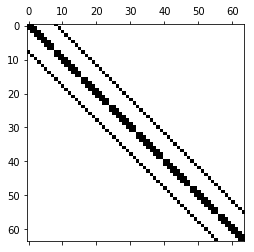

In [199]:
from scipy import sparse
plt.spy(A)

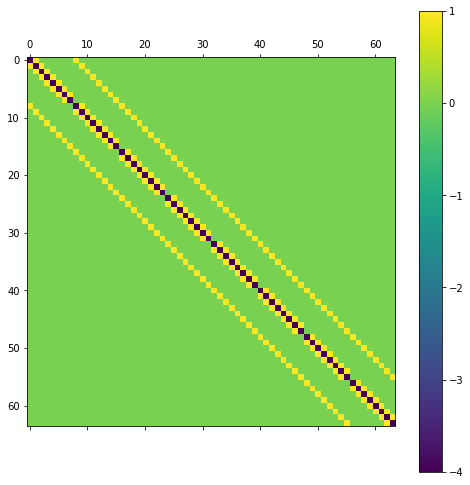

In [213]:
fig= plt.figure(figsize=(8,8))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
axes.matshow(A)
plt.colorbar(mat)
plt.show()

In [217]:
def b(n, val):
    b = np.zeros(n*n)
    for i in range(n):
        b[i]=-val
    return b

b(n,100)

array([-100., -100., -100., -100.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.])

In [202]:
u = LA.solve(A,b(n,100))
u

array([48.63, 66.91, 74.48, 77.35, 77.35, 74.48, 66.91, 48.63, 27.6 ,
       44.55, 53.64, 57.56, 57.56, 53.64, 44.55, 27.6 , 17.23, 30.04,
       37.98, 41.7 , 41.7 , 37.98, 30.04, 17.23, 11.28, 20.41, 26.54,
       29.56, 29.56, 26.54, 20.41, 11.28,  7.48, 13.78, 18.19, 20.44,
       20.44, 18.19, 13.78,  7.48,  4.86,  9.03, 12.02, 13.57, 13.57,
       12.02,  9.03,  4.86,  2.92,  5.45,  7.29,  8.25,  8.25,  7.29,
        5.45,  2.92,  1.37,  2.56,  3.44,  3.9 ,  3.9 ,  3.44,  2.56,
        1.37])

In [203]:
def pad_2D(u2d,val):
    m,n = np.shape(u2d)
    arr = np.block([
        [val*np.ones([1,n+2])],
        [np.zeros([m,1]), u2d, np.zeros([m,1])],
        [np.zeros([1,n+2])]
    ])
    return arr

In [204]:
padu = pad_2D(u.reshape([n,n]),100)
print(padu)

[[100.   100.   100.   100.   100.   100.   100.   100.   100.   100.  ]
 [  0.    48.63  66.91  74.48  77.35  77.35  74.48  66.91  48.63   0.  ]
 [  0.    27.6   44.55  53.64  57.56  57.56  53.64  44.55  27.6    0.  ]
 [  0.    17.23  30.04  37.98  41.7   41.7   37.98  30.04  17.23   0.  ]
 [  0.    11.28  20.41  26.54  29.56  29.56  26.54  20.41  11.28   0.  ]
 [  0.     7.48  13.78  18.19  20.44  20.44  18.19  13.78   7.48   0.  ]
 [  0.     4.86   9.03  12.02  13.57  13.57  12.02   9.03   4.86   0.  ]
 [  0.     2.92   5.45   7.29   8.25   8.25   7.29   5.45   2.92   0.  ]
 [  0.     1.37   2.56   3.44   3.9    3.9    3.44   2.56   1.37   0.  ]
 [  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.  ]]


In [205]:
x = np.linspace(0,1,n+2)
y = np.linspace(0,1,n+2)

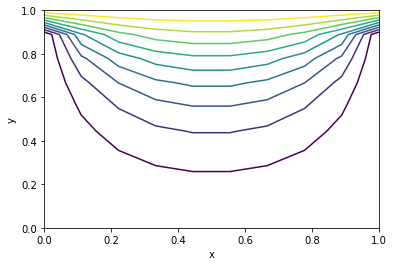

In [206]:
arraycontourplot(x,y,np.flip(padu,0),levels=np.linspace(0,100,11))

## Section 8.3 Fast Poisson Solvers: The Fourier Transform

The next step up from Laplace's equation adds a source term to become the Poisson equation:
$$\nabla^2 u = \omega$$

Would our approach to the Laplace equation extend to handle the Poisson equation? What would need to be changed?

The basic answer is YES as long as we properly include the source term as part of the right-hand side vector $b$, and e know we can solve the resulting linear system using a factorization method that involves $O(N^2)$ operations. That is fine until we want to handle really large domains or really fine discretization and the $O(N^2)$ computation becomes prohibitively expensive (i.e. slow).

Here we introduce an alternative approach with a fundamentally distinct mathematical foundation. Pretty much everything we have done so far has employed Taylor series together with discretization of the domain of the independent variable (typically $x, y, \text{ or } t$).

Here we take a different approach: __Apply the Fourier transform and discretize the frequency domain.__

Let's start with a quick refresher on the Fourier transform pair and related properties. The Fourier transform is an integral transform involving the complex exponential. Integration over the domain of the independent variable transforms a function $f(x)$ into a function $F(k)$ in the wavenumber (or frequency) domain. The Fourier transform has an associated inverse Fourier transfrom (that integrates a function of the wavenumber to transform back to the original (spatial or temporal) domain. Together they form the Fourier transform pair:

\begin{equation}
\begin{split}
F(k) &= \frac{1}{\sqrt{2 \pi}} \int_{-\infty}^{\infty} e^{-ikx} f(x) dx &= \widehat{f(x)}\\
f(x) &= \frac{1}{\sqrt{2 \pi}} \int_{-\infty}^{\infty} e^{ikx} F(k) dk &
\end{split}
\end{equation}

There are other versions (usually with factors of $\sqrt{2 \pi}$ moved around), but we'll stick with this version that has optimal symmetry. Here the integrals are defined over infinite domains, but we will see that there are related transform pairs on finite/discrete domains. Before we get into those details, let's recall the major operational property that makes the Fourier transform useful:

__Fourier transform of the derivative__

\begin{equation}
\begin{split}
\widehat{f'(x)} &= \frac{1}{\sqrt{2 \pi}} \int_{-\infty}^{\infty} e^{-ikx} f'(x) dx & \qquad & \text{   Basic definition}\\
                &= \frac{1}{\sqrt{2 \pi}} f(x) e^{-ikx} \big|_{-\infty}^{\infty} +\frac{ik}{\sqrt{2 \pi}} \int_{-\infty}^{\infty} e^{-ikx} f(x) dx & & \text{   Integration by parts}\\
                &= ik \widehat{f(x)} & & \text{   Assume asymptotic boundedness}
\end{split}
\end{equation}

So the operational property is that differentiation in the original (spatial or temporal) domain transforms to multiplication by $ik$ in the wavenumber domain. This simplification makes the Fourier transform seem attractive, but what really made it important from the perspective of scientific/engineering numerical computation is the invention of the Fast Fourier Transform (FFT) by Cooley and Tukey in the mid-1960s. 

Key properties of the FFT:

- Restrict to a finite interval $x \in [-L,L]$ and assume periodicity.

- Discretize to $N = 2^n$ points regularly spaced across the finite interval.

- Integrals replaced by sums.

- Exponentials give rise to Vandermonde matrices with powers of roots of unity.

- Low operation count $~O(N log N) \implies$ _much_ faster for larger systems.

- Potentially _much_ more accurate compared to methods using finite difference derivative estimates.

The book describes the various Matlab functions related to the Fourier transforms. Here we discuss the analogous python functions which reside in `numpy.fft`

The canonical example of the Fourier transform is the Gaussian function:
$$f(x) = exp(-\alpha x^2)$$
because its transform is also a Gaussian:
$$ \widehat{f(x)} = \frac{1}{\sqrt{2 \alpha}} exp(-\frac{k^2}{4 \alpha}); \qquad \qquad \text{Eq.(8.4.1)}$$
 
As in the text, we start simple with $\alpha = 1$ and choose the interval $x \in [-10,10]$ subdivided into $N = 2^7 = 128$ intervals. The code below replicates Fig. 8.4 using the `numpy.fft` versions of `fft` and `fftshift`. Note that shifting occurs, but we usually do not deal with this explicitly; just employ an inverse transfrom the properly inverts the shift.

[Text(0.5,1,'Magnitude of Shifted Transform')]

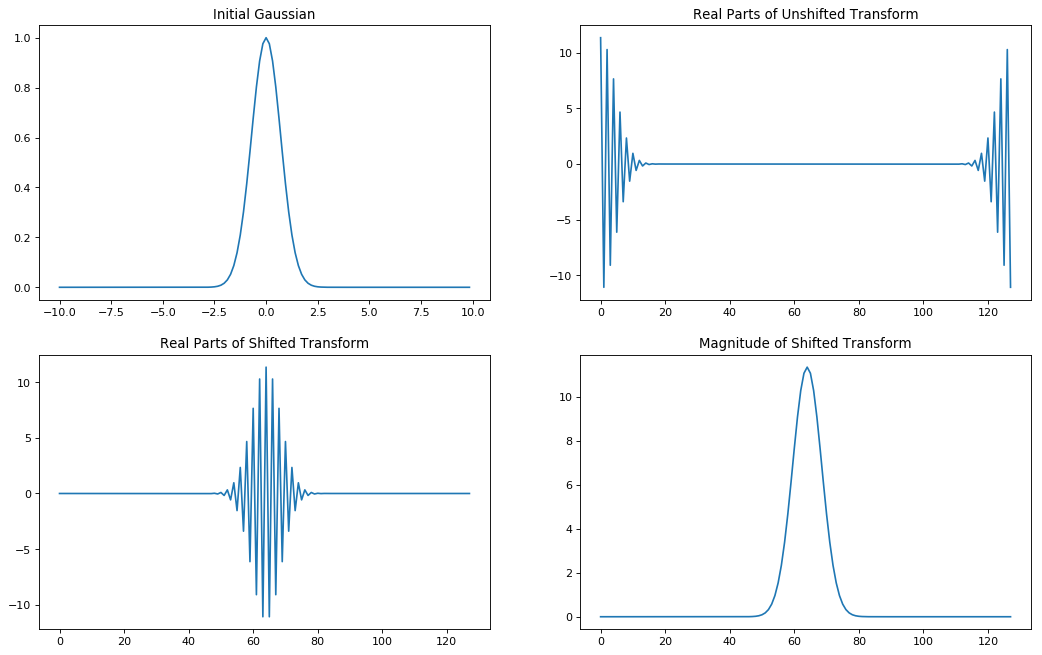

In [226]:
alpha = 1.
L = 20
n = 128

x2 = np.linspace(-L/2,L/2,n+1) #note that this L differs by factor of 2 from L as introduced on p. 188
x = x2[:n]

u = np.exp(-alpha*x*x)
ut = np.fft.fft(u)
utshift = np.fft.fftshift(ut)

fig, ((ax1, ax2), (ax3, ax4))= plt.subplots(nrows=2,ncols=2,figsize=(16,10),facecolor='white',dpi=80)

ax1.plot(x,u); ax1.set(title="Initial Gaussian")
ax2.plot(np.real(ut)); ax2.set(title="Real Parts of Unshifted Transform")
ax3.plot(np.real(utshift)); ax3.set(title="Real Parts of Shifted Transform")
ax4.plot(np.abs(utshift)); ax4.set(title="Magnitude of Shifted Transform")

To illustrate the operational property (and the inverse transform), let's replicate the code on p. 192 that computes the first 2 derivatives of $u(x) = sech(x)$.

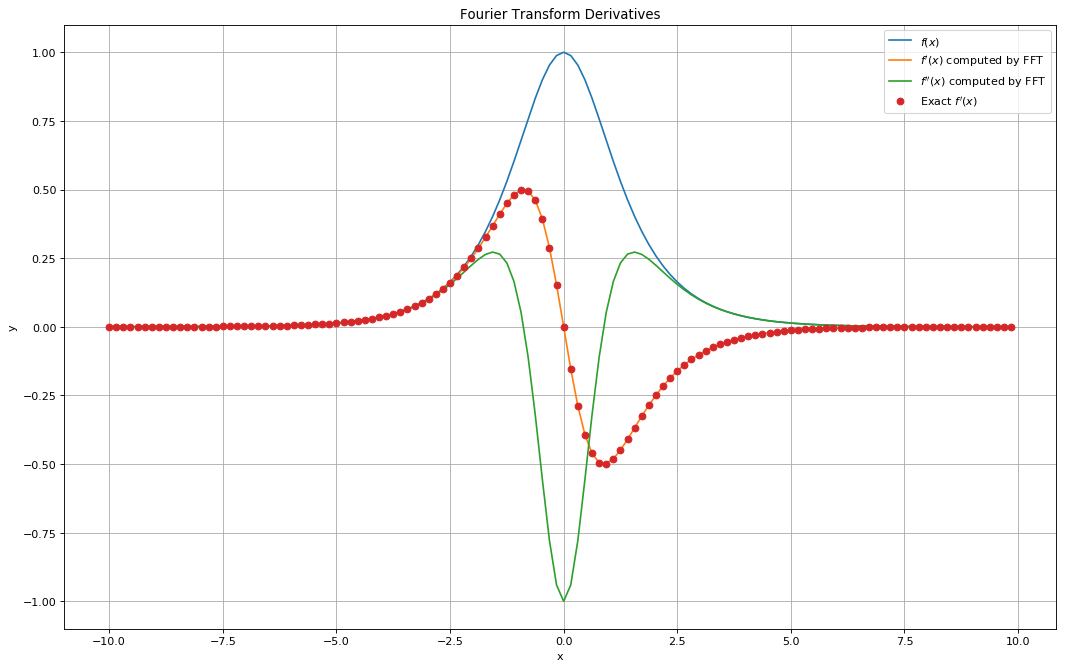

In [225]:
L = 20 #set the finite domain size
n=128  #set the discretization

x2=np.linspace(-L/2,L/2,n+1) #compute coordinates of grid points for n intervals
x=x2[:-1] #drop the last point: it is identified with first point by periodicity
u = 1/np.cosh(x) # define the function
ut = np.fft.fft(u) # compute the FFT

#compute the corresponding discrete wavenumber
k = (2*np.pi/L)*np.array([*range(int(n/2)), *range(int(-n/2),0,1)]) # *range unpacks the range iterator and allows both to be concatenated in one line

df = 1j*k #'1j' is python for sqrt(-1) so 'df*' is "FFTish" for 'd/dx'
ut1 = df*ut    #compute transform of 1st derivative
ut2 = df**2*ut #compute transform of 2nd derivative
ut3 = df**3*ut #compute transform of 3rd derivative

u1 = np.fft.ifft(ut1) #inverse FFT ut1 to get du/dx
u2 = np.fft.ifft(ut2) #inverse FFT ut2 to get d^2u/dx^2
u3 = np.fft.ifft(ut3) #inverse FFT ut1 to get d^3u/dx^3
u1exact = -1./np.cosh(x) * np.tanh(x) #compute analytic first derivative

fig, ax = plt.subplots(figsize=(16,10),facecolor='white',dpi=80)
ax.set(title="Fourier Transform Derivatives",xlabel='x',ylabel='y')
ax.grid(True)
ax.plot(x,u,label="$f(x)$")
ax.plot(x,np.real(u1),label="$f'(x)$ computed by FFT")
ax.plot(x,np.real(u2),label="$f''(x)$ computed by FFT")
ax.plot(x,np.real(u1exact),linestyle='',marker='o',label="Exact $f'(x)$")
# Plot additional derivatives if you like
plt.legend();

The operational property:
$$ f(t) \quad \xrightarrow{\mathcal{F}} \quad \widehat{f}(x)$$

$$ \frac{d^n[f(t)]}{dt^n} \quad \xrightarrow{\mathcal{F}} \quad (ik)^n \widehat{f}(k) $$

often finds application in solving differential equations:

- In the transformed domain, derivatives are replaced by multipliication by a factor involving the wavenumber.

- The differential equation for the solution transforms into an algebraic equation for its transform.

- If the equation is linear, we can solve for the transform and apply the inverse transform to obtain the desired solution.



### Example:

$$y'' - \omega^2 y = -f(x); \quad x \in [-\infty, \infty] $$

$$ \widehat{y''} - \omega^2 \widehat{y} = -\widehat{f}$$

$$ -k^2\widehat{y} - \omega^2\widehat{y} = -\widehat{f}$$

$$ (k^2 + \omega^2)\widehat{y} = \widehat{f} $$

$$ \widehat{y} = \frac{ \widehat{f} }{ k^2 + \omega^2} $$

$$ y(x) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} e^{ikx} \widehat{y}\space dk = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} e^{ikx} \frac{ \widehat{f} }{ k^2 + \omega^2}\space dk$$

### Note:
There is some notation "mixing" among the internet and this book. In many cases, you'll find the definition of the Fourier Transform differing in terms of independent frequency domain variable: $\omega$, $f$, or in this case $k$. In this example, the independent variable is $k$ and $\omega$ is a constant, which might lead to confusion if you go searching on the internet.

We will now push on to "Ch. 9 Time and Space Stepping Schemes: The Method of Lines" and then return to look at Fourier transform methods when we get to "Ch. 10 Spectal Methods".